In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#!{sys.executable} -m pip install bayesian_optimization

# SETTINGS
seed = 124
np.random.seed(seed)
np.set_printoptions(precision=14)

test_size = 0.2

In [2]:
def get_data():

    ## train & test paths
    data_dir = "./data/"

    ### csv w/ layout: "y,x1,x2,x3,x4,x5"
    train_features_file = data_dir+"train_features_imputed.csv"
    train_labels_file = data_dir+"train_labels.csv"
    test_features_file = data_dir+"test_features_imputed.csv"
    
    data_type = np.double # np dtype object for values in X and Y

    train_features = pd.read_csv(train_features_file)
    train_labels = pd.read_csv(train_labels_file)
    test_features = pd.read_csv(test_features_file)

    return train_features, train_labels, test_features

In [3]:
train_features, train_labels, test_features = get_data()

In [22]:

preprocessed_train_features = pd.read_csv("./data/preprocessed_train_features.csv")
preprocessed_test_features = pd.read_csv("./data/preprocessed_test_features.csv")

In [23]:

preprocessed_train_features.fillna(preprocessed_train_features.mean(), inplace=True)
preprocessed_test_features.fillna(preprocessed_train_features.mean(), inplace=True)

In [24]:

preprocessed_train_features.sort_values('pid', inplace=True)
preprocessed_test_features.sort_values('pid', inplace=True)
train_labels.sort_values('pid', inplace=True)

# 1. Subtask
labels_to_predict = ["LABEL_BaseExcess", "LABEL_Fibrinogen", "LABEL_AST", "LABEL_Alkalinephos", "LABEL_Bilirubin_total", "LABEL_Lactate", "LABEL_TroponinI", "LABEL_SaO2", "LABEL_Bilirubin_direct", "LABEL_EtCO2"]
y1 = train_labels[labels_to_predict]
print(y1.info())
preprocessed_train_features.drop('pid', axis=1, inplace=True)
preprocessed_test_pids = preprocessed_test_features["pid"]
preprocessed_test_features.drop('pid', axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18995 entries, 0 to 14406
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   LABEL_BaseExcess        18995 non-null  float64
 1   LABEL_Fibrinogen        18995 non-null  float64
 2   LABEL_AST               18995 non-null  float64
 3   LABEL_Alkalinephos      18995 non-null  float64
 4   LABEL_Bilirubin_total   18995 non-null  float64
 5   LABEL_Lactate           18995 non-null  float64
 6   LABEL_TroponinI         18995 non-null  float64
 7   LABEL_SaO2              18995 non-null  float64
 8   LABEL_Bilirubin_direct  18995 non-null  float64
 9   LABEL_EtCO2             18995 non-null  float64
dtypes: float64(10)
memory usage: 1.6 MB
None


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(preprocessed_train_features, y1, test_size=test_size, random_state=seed)

In [8]:
X_train, y_train

(         EtCO2_0      PTT_0      BUN_0  Lactate_0     Temp_0      Hgb_0  \
 13893  32.711509  39.008197  37.000000   2.420076  36.500000  10.743874   
 2798   35.388889  39.008197  11.000000   2.420076  36.500000  12.000000   
 11247  32.711509  39.008197  23.013833   2.420076  36.500000  10.743874   
 18198  32.711509  39.008197   7.000000   2.420076  37.000000  11.000000   
 17653  32.711509  39.008197  19.000000   2.420076  37.000000  13.100000   
 ...          ...        ...        ...        ...        ...        ...   
 681    32.711509  39.008197   9.000000   2.420076  36.333333  10.900000   
 9154   32.711509  39.008197  34.000000   2.923333  36.909091  10.000000   
 14353  32.711509  39.008197  24.000000   2.850000  38.000000  13.200000   
 4764   32.711509  34.000000  23.013833   2.420076  37.000000  10.743874   
 4558   32.711509  39.008197  18.000000   2.420076  37.000000  13.700000   
 
           HCO3_0  BaseExcess_0    RRate_0  Fibrinogen_0  ...  SpO2_11  \
 13893  23.7

In [9]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
import keras
from keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from keras.layers import BatchNormalization

print(X_train.iloc[0], y_train.iloc[0])

# from: https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

print(X_train, y_train)



EtCO2_0                32.711509
PTT_0                  39.008197
BUN_0                  37.000000
Lactate_0               2.420076
Temp_0                 36.500000
                         ...    
Bilirubin_total_11      1.543193
TroponinI_11            0.100000
ABPs_11               112.000000
pH_11                   7.377429
Age                    46.000000
Name: 13893, Length: 409, dtype: float64 LABEL_BaseExcess          0.0
LABEL_Fibrinogen          0.0
LABEL_AST                 0.0
LABEL_Alkalinephos        0.0
LABEL_Bilirubin_total     0.0
LABEL_Lactate             0.0
LABEL_TroponinI           1.0
LABEL_SaO2                1.0
LABEL_Bilirubin_direct    0.0
LABEL_EtCO2               0.0
Name: 8726, dtype: float64
         EtCO2_0      PTT_0      BUN_0  Lactate_0     Temp_0      Hgb_0  \
13893  32.711509  39.008197  37.000000   2.420076  36.500000  10.743874   
2798   35.388889  39.008197  11.000000   2.420076  36.500000  12.000000   
11247  32.711509  39.008197  23.013833   2.4

LABEL_BaseExcess
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 1000)              410000    
                                                                 
 dense_31 (Dense)            (None, 1000)              1001000   
                                                                 
 batch_normalization_10 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 1000)              0         
                                                                 
 dense_32 (Dense)            (None, 2)                 2002      
                                                                 
Total params: 1,417,002
Trainable params: 1,415,002
Non-trainable params: 2,000
______________________

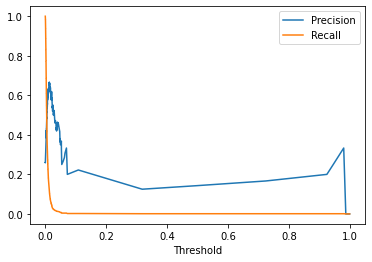

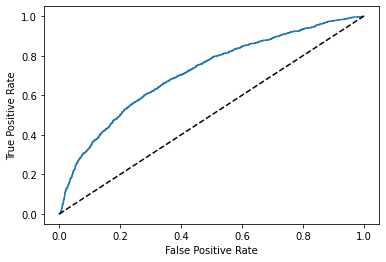

LABEL_Fibrinogen
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 1000)              410000    
                                                                 
 dense_34 (Dense)            (None, 1000)              1001000   
                                                                 
 batch_normalization_11 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dropout_11 (Dropout)        (None, 1000)              0         
                                                                 
 dense_35 (Dense)            (None, 2)                 2002      
                                                                 
Total params: 1,417,002
Trainable params: 1,415,002
Non-trainable params: 2,000
______________________

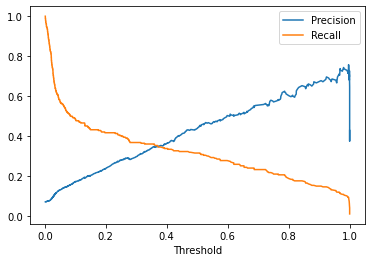

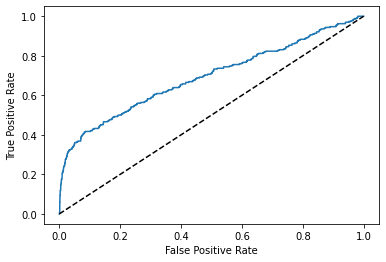

LABEL_AST
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 1000)              410000    
                                                                 
 dense_37 (Dense)            (None, 1000)              1001000   
                                                                 
 batch_normalization_12 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 1000)              0         
                                                                 
 dense_38 (Dense)            (None, 2)                 2002      
                                                                 
Total params: 1,417,002
Trainable params: 1,415,002
Non-trainable params: 2,000
_____________________________

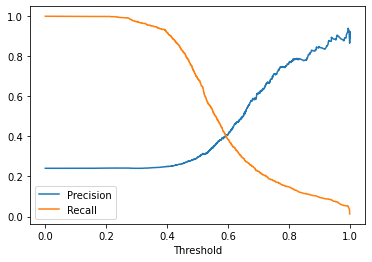

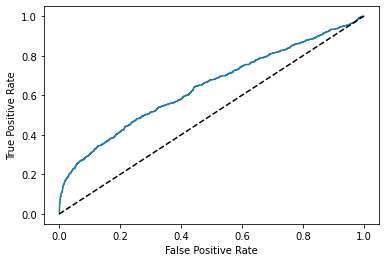

LABEL_Alkalinephos
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 1000)              410000    
                                                                 
 dense_40 (Dense)            (None, 1000)              1001000   
                                                                 
 batch_normalization_13 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dropout_13 (Dropout)        (None, 1000)              0         
                                                                 
 dense_41 (Dense)            (None, 2)                 2002      
                                                                 
Total params: 1,417,002
Trainable params: 1,415,002
Non-trainable params: 2,000
____________________

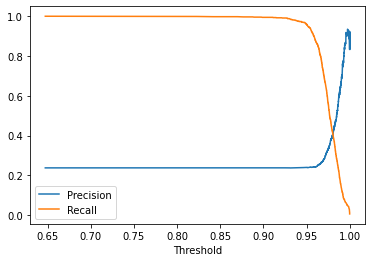

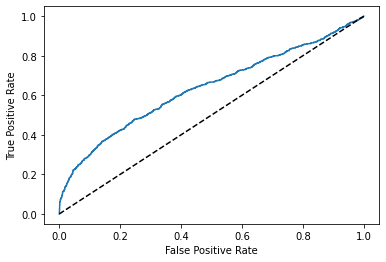

LABEL_Bilirubin_total
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 1000)              410000    
                                                                 
 dense_43 (Dense)            (None, 1000)              1001000   
                                                                 
 batch_normalization_14 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dropout_14 (Dropout)        (None, 1000)              0         
                                                                 
 dense_44 (Dense)            (None, 2)                 2002      
                                                                 
Total params: 1,417,002
Trainable params: 1,415,002
Non-trainable params: 2,000
_________________

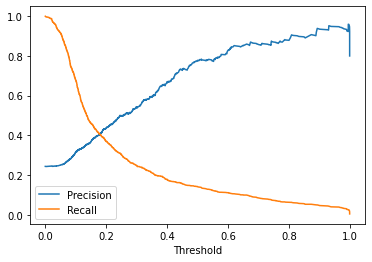

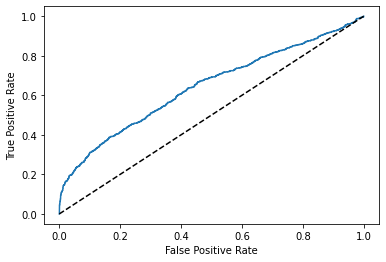

LABEL_Lactate
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_45 (Dense)            (None, 1000)              410000    
                                                                 
 dense_46 (Dense)            (None, 1000)              1001000   
                                                                 
 batch_normalization_15 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dropout_15 (Dropout)        (None, 1000)              0         
                                                                 
 dense_47 (Dense)            (None, 2)                 2002      
                                                                 
Total params: 1,417,002
Trainable params: 1,415,002
Non-trainable params: 2,000
_________________________

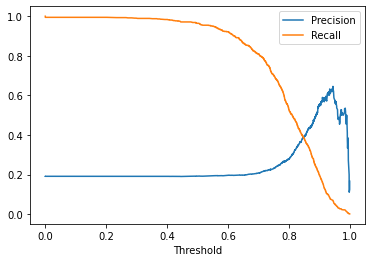

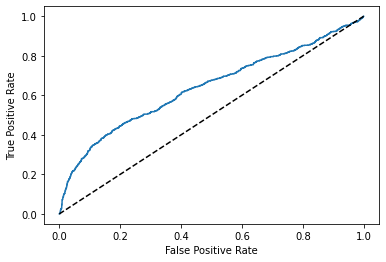

LABEL_TroponinI
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 1000)              410000    
                                                                 
 dense_49 (Dense)            (None, 1000)              1001000   
                                                                 
 batch_normalization_16 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 1000)              0         
                                                                 
 dense_50 (Dense)            (None, 2)                 2002      
                                                                 
Total params: 1,417,002
Trainable params: 1,415,002
Non-trainable params: 2,000
_______________________

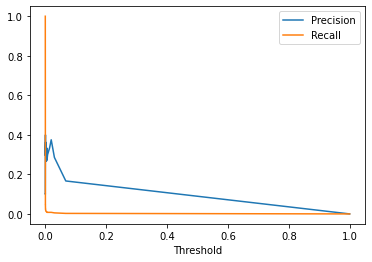

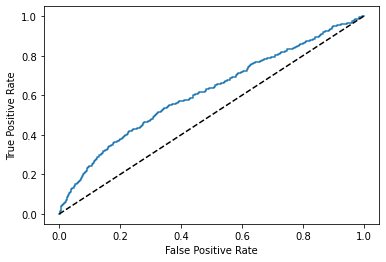

LABEL_SaO2
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_51 (Dense)            (None, 1000)              410000    
                                                                 
 dense_52 (Dense)            (None, 1000)              1001000   
                                                                 
 batch_normalization_17 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dropout_17 (Dropout)        (None, 1000)              0         
                                                                 
 dense_53 (Dense)            (None, 2)                 2002      
                                                                 
Total params: 1,417,002
Trainable params: 1,415,002
Non-trainable params: 2,000
____________________________

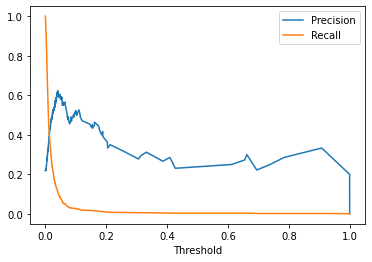

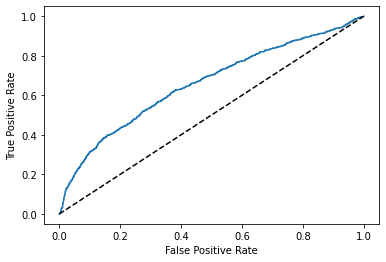

LABEL_Bilirubin_direct
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 1000)              410000    
                                                                 
 dense_55 (Dense)            (None, 1000)              1001000   
                                                                 
 batch_normalization_18 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 1000)              0         
                                                                 
 dense_56 (Dense)            (None, 2)                 2002      
                                                                 
Total params: 1,417,002
Trainable params: 1,415,002
Non-trainable params: 2,000
________________

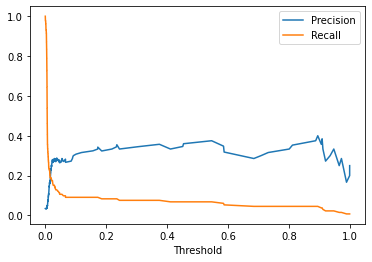

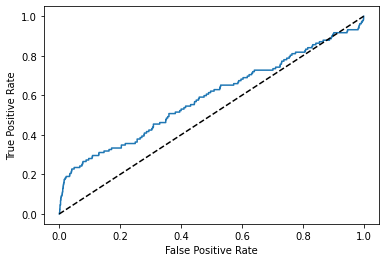

LABEL_EtCO2
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 1000)              410000    
                                                                 
 dense_58 (Dense)            (None, 1000)              1001000   
                                                                 
 batch_normalization_19 (Bat  (None, 1000)             4000      
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 1000)              0         
                                                                 
 dense_59 (Dense)            (None, 2)                 2002      
                                                                 
Total params: 1,417,002
Trainable params: 1,415,002
Non-trainable params: 2,000
___________________________

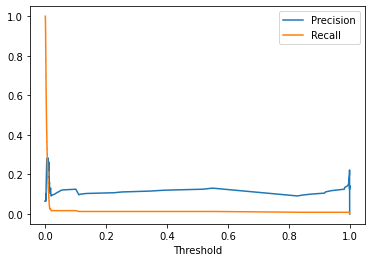

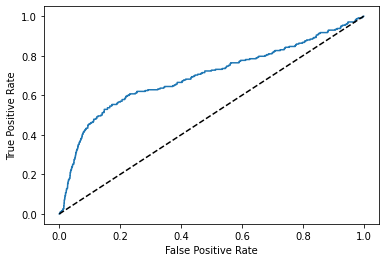

       LABEL_BaseExcess  LABEL_Fibrinogen  LABEL_AST  LABEL_Alkalinephos  \
0              0.012716          0.802698   0.919795            0.997660   
1              0.003214          0.029405   0.601104            0.976900   
2              0.003157          0.020665   0.430894            0.968516   
3              0.003134          0.999992   0.999999            0.999900   
4              0.002235          0.010889   0.548601            0.978041   
...                 ...               ...        ...                 ...   
12659          0.002600          0.025687   0.472727            0.970744   
12660          0.016127          0.123331   0.667208            0.970673   
12661          0.001458          0.016060   0.461907            0.969572   
12662          0.002709          0.015727   0.609496            0.974990   
12663          0.003657          0.035364   0.641386            0.978719   

       LABEL_Bilirubin_total  LABEL_Lactate  LABEL_TroponinI  LABEL_SaO2  \
0          

In [15]:
from sklearn import preprocessing
preds_arr = []
for label in labels_to_predict:
    print(label)
    # clf = LogisticRegressionCV(class_weight='balanced', penalty='l2', n_jobs=6, cv=10, max_iter=1000, scoring="roc_auc", random_state=seed)
    # clf = LinearSVC(probability=True, class_weight='balanced', kernel='linear')
    # regr = make_pipeline(StandardScaler(), SVR(C=1, epsilon=0.1))
    
    
    # cv = RandomizedSearchCV(
    #     SVR(), 
    #     {
    #         "C": [0.5, 1.0], 
    #         "epsilon": [0.1, 0.2]
    #     }, 
    #     cv=5, 
    #     n_jobs=4, 
    #     scoring="roc_auc", 
    #     random_state=seed, 
    #     verbose=1)
    # search = RandomCV(pipe, param_grid, n_jobs=2)
    # search.fit(X_digits, y_digits)
    # print("Best parameter (CV score=%0.3f):" % search.best_score_)
    # print(search.best_params_)

    # wanted_features = [l for l in X_train.columns if "_".join(label.split("_")[1:]) in l]
    # wanted_features.append("Age")
    # print(wanted_features)
    # X_train_filtered = X_train#[wanted_features]
    # X_test_filtered = X_test#[wanted_features]
    # print(X_train_filtered)
    
    # scaler = preprocessing.StandardScaler().fit(X_train_filtered)    
    # X_train_scaled = scaler.transform(X_train_filtered)
    # X_test_scaled = scaler.transform(X_test_filtered)
    # print(X_train_scaled)
    # clf.fit(X_train_scaled, y_train[label])
    # print(X_train_filtered)
    # cv.fit(X_train_filtered, y_train[label])

    model = Sequential() # create a sequential model
    model.add(Dense(1000, # output neurons in layer       
            input_dim=X_train.shape[1], # number of inputs
            activation='relu')) # activation function
    model.add(BatchNormalization())
    model.add(Dense(1000, activation='relu')) # hidden layer
    model.add(Dropout(0.5)) 
    # model.add(BatchNormalization())
    model.add(Dense(2, activation='softmax')) # output layer
    model.summary()

    # fit the model
    callback = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
    model.compile(loss='binary_crossentropy', # cost function
              optimizer='adam', # use adam as the optimizer
              metrics=['accuracy', keras.metrics.AUC(),f1_m,precision_m, recall_m]) # compute accuracy, for scoring
    model_info = model.fit(X_train, to_categorical(y_train[label]), 
        epochs=100,
        validation_split=.10,
        callbacks=[callback])
    
    # loss, accuracy, auc, f1_score, precision, recall = model.evaluate(X_test, to_categorical(y_test[label]), verbose=1)
    # print(f"loss: {loss}, auc: {auc}, accuracy: {accuracy}, f1_score: {f1_score}, precision: {precision}, recall: {recall}")
    pred = model.predict(X_test)
    pred_train = model.predict(X_train)
    pred_test = model.predict(preprocessed_test_features)
    print(pred, pred_train)
    pred = pred.squeeze()[:,1]
    pred_train = pred_train.squeeze()[:,1]
    pred_test = pred_test.squeeze()[:,1]
    # pred = clf.predict_proba(X_test_scaled)[:, 1]
    # pred_train = clf.predict_proba(X_train_scaled)[:, 1]
    # pred = cv.predict(X_test_scaled)
    # pred_train = cv.predict(X_train_scaled)
    print(pred, pred.var())

    preds_arr.append(pd.DataFrame(pred_test, columns=[label]))
    # pred = clf.predict_proba(X_test_scaled)
    # score = roc_auc_score(y_test[label], pred[:, 1])
    # score = roc_auc_score(y_test[label], pred)
    # train_score = roc_auc_score(y_train[label], pred_train)
    # print(f"roc auc score: {score}", train_score)


    precisions, recalls, thresholds = precision_recall_curve(y_test[label], pred)

    plt.plot(thresholds, precisions[:-1], label="Precision")
    plt.plot(thresholds, recalls[:-1], label="Recall")
    plt.xlabel('Threshold')
    plt.legend()
    plt.show()

    # mean_squared_error(y_test["LABEL_BaseExcess"], pred[:, 1])
    # fpr, tpr, thresholds = roc_curve(y_test[label], pred[:, 1])
    fpr, tpr, thresholds = roc_curve(y_test[label], pred)
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

preds_arr.append(preprocessed_test_pids)
preds = pd.concat(preds_arr, axis=1)
preds["pid"] = preds["pid"].astype(int)
print(preds)

In [52]:
def save_submission(submission):

    ## prediction submission paths
    sub_dir = "./submission/"
    sub_file = "submission2.csv"
    sub_path = sub_dir + sub_file


    if not os.path.isdir(sub_dir):
        os.mkdir(sub_dir)


    ## submission csv header
    # sub_header = ""
    # sub_format = "%.13f"
    submission.to_csv(sub_path, index=False)

In [57]:
preds2 = pd.concat([preds, pd.DataFrame(np.zeros((len(preds), 5)), columns=["LABEL_Sepsis","LABEL_RRate","LABEL_ABPm","LABEL_SpO2","LABEL_Heartrate"])], axis=1)

In [58]:
preds2

,LABEL_BaseExcess,LABEL_Fibrinogen,LABEL_AST,LABEL_Alkalinephos,LABEL_Bilirubin_total,LABEL_Lactate,LABEL_TroponinI,LABEL_SaO2,LABEL_Bilirubin_direct,LABEL_EtCO2,pid,LABEL_Sepsis,LABEL_RRate,LABEL_ABPm,LABEL_SpO2,LABEL_Heartrate
0,0.012716,0.802698,0.919795,0.997660,0.901496,0.899703,0.000024,0.011027,0.027887,0.001292,0,0.0,0.0,0.0,0.0,0.0
1,0.003214,0.029405,0.601104,0.976900,0.130727,0.796084,0.000074,0.007266,0.005980,0.002123,3,0.0,0.0,0.0,0.0,0.0
2,0.003157,0.020665,0.430894,0.968516,0.065801,0.791697,0.000048,0.010196,0.005941,0.002412,5,0.0,0.0,0.0,0.0,0.0
3,0.003134,0.999992,0.999999,0.999900,0.999747,0.000000,0.000470,0.499494,0.839807,0.876849,7,0.0,0.0,0.0,0.0,0.0
4,0.002235,0.010889,0.548601,0.978041,0.109673,0.703480,0.000072,0.003515,0.005621,0.001168,9,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12659,0.002600,0.025687,0.472727,0.970744,0.083173,0.773220,0.000038,0.004174,0.006180,0.002221,31647,0.0,0.0,0.0,0.0,0.0
12660,0.016127,0.123331,0.667208,0.970673,0.091830,0.916101,0.000130,0.012939,0.006955,0.004167,31649,0.0,0.0,0.0,0.0,0.0
12661,0.001458,0.016060,0.461907,0.969572,0.080946,0.658633,0.000034,0.010623,0.006228,0.002147,31651,0.0,0.0,0.0,0.0,0.0
12662,0.002709,0.015727,0.609496,0.974990,0.128180,0.697816,0.000052,0.004303,0.005055,0.002175,31652,0.0,0.0,0.0,0.0,0.0


In [59]:
save_submission(preds2)
